# Visualización del dataset

Ver https://github.com/SoccerNet/sn-tracking/blob/main/README.md

"The ground truth and detections are stored in comma-separate csv files with 10 columns (en realidad son .txt, altos villeros). These values correspond in order to: frame ID, track ID, top left coordinate of the bounding box, top y coordinate, width, height, confidence score for the detection (always 1. for the ground truth) and the remaining values are set to -1 as they are not used in our dataset, but are needed to comply with the MOT20 requirements"


### **Importante**

Este notebook es sólo para tranformar los labels del dataset de SoccerNet, en uno para YOLO



In [ ]:
# TODO: Mergear src/train/ball/transformation.ipynb con este archivo

In [14]:
import os
import random
import shutil
import cv2
import configparser

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib.patches import Rectangle


In [ ]:
BASE = Path("../../..")
SAMPLE = Path("data/tracking/raw/train/SNMOT-060")

In [16]:
for entry in sorted(SAMPLE.iterdir()):
    if entry.is_dir():
        child_names = sorted(child.name for child in entry.iterdir())
        print(f"{entry.name}/")
        preview = child_names[:5]
        for name in preview:
            print(f"  {name}")
        if len(child_names) > len(preview):
            print(f"  … ({len(child_names) - len(preview)} more)")
    else:
        print(entry.name)

det/
  det.txt
gameinfo.ini
gt/
  gt.txt
img1/
  000001.jpg
  000002.jpg
  000003.jpg
  000004.jpg
  000005.jpg
  … (745 more)
seqinfo.ini


In [17]:
seq_cfg = configparser.ConfigParser()
seq_cfg.read(SAMPLE / "seqinfo.ini")
seq_info = pd.DataFrame(seq_cfg["Sequence"].items(), columns=["key", "value"]).set_index("key")
print("Sequence metadata")
display(seq_info)

game_cfg = configparser.ConfigParser()
game_cfg.read(SAMPLE / "gameinfo.ini")
game_info = pd.DataFrame(game_cfg["Sequence"].items(), columns=["key", "value"]).set_index("key")
print("Game metadata")
display(game_info)

Sequence metadata


,value
key,
name,SNMOT-060
imdir,img1
framerate,25
seqlength,750
imwidth,1920
imheight,1080
imext,.jpg


Game metadata


,value
key,
name,SNMOT-060
gameid,4
actionposition,895
actionclass,Kick-off
visibility,visible
clipstart,0
gametimestart,1 - 00:00
clipstop,30000
gametimestop,1 - 00:30


In [18]:
COLUMNS = [
    "frame","id","bb_left","bb_top","bb_width","bb_height","confidence","x","y","z"
 ]

det_path = SAMPLE / "det" / "det.txt"
gt_path = SAMPLE / "gt" / "gt.txt"

det_df = pd.read_csv(det_path, header=None, names=COLUMNS)
gt_df = pd.read_csv(gt_path, header=None, names=COLUMNS)


print(f"Detections: {len(det_df):,} boxes across {det_df['frame'].nunique()} frames")
print(f"Ground truth: {len(gt_df):,} boxes, {gt_df['id'].nunique()} unique track IDs")
display(det_df.head())
display(gt_df.head())

Detections: 13,540 boxes across 750 frames
Ground truth: 13,540 boxes, 26 unique track IDs


,frame,id,bb_left,bb_top,bb_width,bb_height,confidence,x,y,z
0,1,-1,914,855,55,172,1,-1,-1,-1
1,1,-1,917,575,32,122,1,-1,-1,-1
2,1,-1,956,557,53,133,1,-1,-1,-1
3,1,-1,1257,673,44,141,1,-1,-1,-1
4,1,-1,1888,400,30,101,1,-1,-1,-1


,frame,id,bb_left,bb_top,bb_width,bb_height,confidence,x,y,z
0,1,1,914,855,55,172,1,-1,-1,-1
1,2,1,907,855,67,172,1,-1,-1,-1
2,3,1,901,855,79,172,1,-1,-1,-1
3,4,1,894,854,92,173,1,-1,-1,-1
4,5,1,888,854,104,173,1,-1,-1,-1


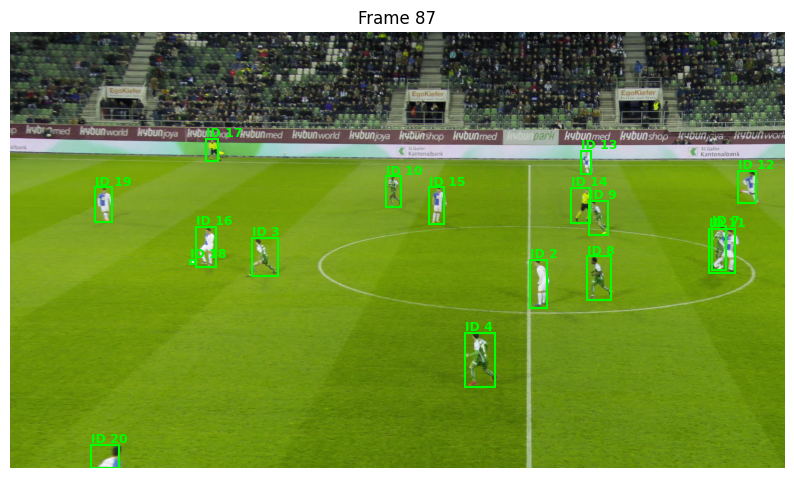

In [19]:
frame_to_plot = random.randint(0, det_df['frame'].nunique())

image_path = SAMPLE / "img1" / f"{frame_to_plot:06d}.jpg"
frame_boxes = gt_df[gt_df["frame"] == frame_to_plot]

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(plt.imread(image_path))
for _, box in frame_boxes.iterrows():
    rect = Rectangle(
        (box["bb_left"], box["bb_top"]),
        box["bb_width"],
        box["bb_height"],
        linewidth=1.5,
        edgecolor="lime",
        facecolor="none"
    )
    ax.add_patch(rect)
    ax.text(
        box["bb_left"],
        box["bb_top"] - 5,
        f"ID {int(box['id'])}",
        color="lime",
        fontsize=9,
        weight="bold"
    )
ax.set_title(f"Frame {frame_to_plot}")
ax.set_axis_off()
plt.show()

# Transformación

Para el modelo baseline hay que armar un YOLO con las clases `player`, `referee` y `ball`, después se trabaja lo de distinguir y trackear a los jugadores, entonces hay que modificar los labels. 

Además, YOLO usa este formato

```
dataset/
  images/
    train/
      SNMOT-060_000001.jpg
      SNMOT-060_000002.jpg
      ...
    val/
  labels/
    train/
      SNMOT-060_000001.txt
      SNMOT-060_000002.txt
      ...
    val/
```

Asi que tambien hay que cambiar eso y **hacer el split de validación**

In [20]:
RAW_ROOT = Path("data/tracking/raw/train")

YOLO_ROOT = Path("data/tracking/YOLO")

IMAGES_DIR = YOLO_ROOT / "images"
LABELS_DIR = YOLO_ROOT / "labels"

USE_SYMLINKS = True

CLASS_MAP = {
    "player": 0,
    "referee": 1,
    "ball": 2,
    "goalkeeper": 3
}

YOLO_ROOT.mkdir(parents=True, exist_ok=True)
(IMAGES_DIR / "train").mkdir(parents=True, exist_ok=True)
(IMAGES_DIR / "val").mkdir(parents=True, exist_ok=True)
(LABELS_DIR / "train").mkdir(parents=True, exist_ok=True)
(LABELS_DIR / "val").mkdir(parents=True, exist_ok=True)

print("RAW_ROOT:", RAW_ROOT.resolve())
print("YOLO_ROOT:", YOLO_ROOT.resolve())

RAW_ROOT: /home/valen/tp-furbo/data/tracking/raw/train
YOLO_ROOT: /home/valen/tp-furbo/data/tracking/YOLO


## Crear YAML

In [21]:
import json

yaml_path = YOLO_ROOT / "tracker.yaml"
class_names = [None] * len(CLASS_MAP)
for name, idx in CLASS_MAP.items():
    class_names[idx] = name

yaml_lines = [
    f"path: {YOLO_ROOT.resolve()}",
    "train: images/train",
    "val: images/val",
    "names: " + json.dumps(class_names),
    f"nc: {len(class_names)}",
]

yaml_path.parent.mkdir(parents=True, exist_ok=True)
with open(yaml_path, "w") as f:
    f.write("\n".join(yaml_lines) + "\n")

print("YOLO YAML saved to", yaml_path)

YOLO YAML saved to data/tracking/YOLO/tracker.yaml


In [22]:
# Cell 2: helper functions

def parse_tracklet_tags(gameinfo_path: Path) -> dict:
    """
    Parse gameinfo.ini and return {track_id (int) -> raw_tag (str)}.
    Example raw_tag: "player team left;24", "referee;main", "ball;1", "goalkeepers team left;c"
    """
    config = configparser.ConfigParser()
    config.optionxform = str  # preserve case of keys
    config.read(gameinfo_path)

    seq_section = config["Sequence"]
    num_tracklets = int(seq_section["num_tracklets"])

    tracklet_tags = {}
    for k in range(1, num_tracklets + 1):
        key = f"trackletID_{k}"
        if key in seq_section:
            tag = seq_section[key].strip()
            tracklet_tags[k] = tag
    return tracklet_tags


def obj_type_from_tag(tag):
    """
    Parses the raw tag string from gameinfo.ini (e.g., 'player team left;10')
    and returns the standardized object category.
    """
    if not isinstance(tag, str):
        return None
    
    tag_lower = tag.lower()
    
    # Check for goalkeeper first to ensure it's categorized correctly
    if "goalkeeper" in tag_lower:
        return "player"
    elif "player" in tag_lower:
        return "player"
    elif "referee" in tag_lower:
        return "referee"
    elif "ball" in tag_lower:
        return "ball"
    
    return None


def ensure_symlink_or_copy(src: Path, dst: Path, use_symlink: bool = True):
    """
    Create a symlink to src at dst, or copy if symlinks are disabled or fail.
    """
    if dst.exists():
        return  # already created

    dst.parent.mkdir(parents=True, exist_ok=True)

    if use_symlink:
        try:
            os.symlink(src.resolve(), dst)
            return
        except OSError:
            # Fall back to copy if symlink not allowed
            pass

    shutil.copy2(src, dst)


In [23]:
seq_dirs = sorted([p for p in RAW_ROOT.glob("SNMOT-*") if p.is_dir()])
print(f"Found {len(seq_dirs)} sequences under {RAW_ROOT}")

train_ratio = 0.8
split_idx = int(len(seq_dirs) * train_ratio)

train_seqs = {p.name for p in seq_dirs[:split_idx]}
val_seqs = {p.name for p in seq_dirs[split_idx:]}

print(f"Train sequences: {len(train_seqs)}")
print(f"Val sequences:   {len(val_seqs)}")
print("Example train seqs:", list(sorted(train_seqs))[:5])
print("Example val seqs:  ", list(sorted(val_seqs))[:5])

Found 57 sequences under data/tracking/raw/train
Train sequences: 45
Val sequences:   12
Example train seqs: ['SNMOT-060', 'SNMOT-061', 'SNMOT-062', 'SNMOT-063', 'SNMOT-064']
Example val seqs:   ['SNMOT-159', 'SNMOT-160', 'SNMOT-161', 'SNMOT-162', 'SNMOT-163']


In [24]:
# Cell 4: main loop to populate YOLO dataset

def process_sequence(seq_dir: Path):
    """
    Convert one SNMOT-* sequence into YOLO images+labels.
    """
    seq_name = seq_dir.name  # e.g. "SNMOT-064"
    img_dir = seq_dir / "img1"
    gt_path = seq_dir / "gt" / "gt.txt"
    gameinfo_path = seq_dir / "gameinfo.ini"

    assert img_dir.is_dir(), f"Missing img1 dir in {seq_dir}"
    assert gt_path.is_file(), f"Missing gt.txt in {seq_dir}"
    assert gameinfo_path.is_file(), f"Missing gameinfo.ini in {seq_dir}"

    # Decide whether this sequence goes to train or val
    split = "train" if seq_name in train_seqs else "val"

    # Read tracklet tags from gameinfo.ini
    tracklet_tags = parse_tracklet_tags(gameinfo_path)

    # Read MOT ground truth
    df = pd.read_csv(
        gt_path,
        header=None,
        names=["frame", "track_id", "bb_left", "bb_top", "bb_width", "bb_height",
               "confidence", "x", "y", "z"],
    )

    # Map track_id -> raw tag
    df["tag"] = df["track_id"].map(tracklet_tags)

    # Map tag -> object type ('player', 'referee', 'ball', None)
    df["obj_type"] = df["tag"].apply(obj_type_from_tag)

    # Keep only rows that map to one of our classes
    df = df[df["obj_type"].notna()].copy()
    if df.empty:
        print(f"[{seq_name}] no usable objects, skipping.")
        return

    # Get image size from first frame
    sample_img_path = img_dir / "000001.jpg"
    if not sample_img_path.is_file():
        raise FileNotFoundError(f"Sample image not found: {sample_img_path}")

    img = cv2.imread(str(sample_img_path))
    if img is None:
        raise RuntimeError(f"Failed to read sample image: {sample_img_path}")

    img_h, img_w = img.shape[:2]

    # Compute YOLO-normalized coordinates
    df["x_center"] = df["bb_left"] + df["bb_width"] / 2.0
    df["y_center"] = df["bb_top"] + df["bb_height"] / 2.0
    df["x_center_norm"] = df["x_center"] / img_w
    df["y_center_norm"] = df["y_center"] / img_h
    df["w_norm"] = df["bb_width"] / img_w
    df["h_norm"] = df["bb_height"] / img_h

    # Map obj_type -> class_id
    df["class_id"] = df["obj_type"].map(CLASS_MAP)

    # Group by frame to write one YOLO label file per frame
    grouped = df.groupby("frame")

    num_frames = 0
    num_objects = 0

    for frame_id, g in grouped:
        frame_id = int(frame_id)

        # Source image file: 000001.jpg, 000002.jpg, ...
        src_img_name = f"{frame_id:06d}.jpg"
        src_img_path = img_dir / src_img_name
        if not src_img_path.is_file():
            # Skip labels for frames where we don't have the image (shouldn't happen)
            continue

        # Target image/label names: SNMOT-064_000001.jpg / .txt
        base_name = f"{seq_name}_{frame_id:06d}"
        dst_img_path = IMAGES_DIR / split / f"{base_name}.jpg"
        dst_label_path = LABELS_DIR / split / f"{base_name}.txt"

        # Create image symlink/copy if not already present
        ensure_symlink_or_copy(src_img_path, dst_img_path, use_symlink=USE_SYMLINKS)

        # Write YOLO label file
        lines = []
        for _, row in g.iterrows():
            class_id = int(row["class_id"])
            x_c = float(row["x_center_norm"])
            y_c = float(row["y_center_norm"])
            w_n = float(row["w_norm"])
            h_n = float(row["h_norm"])

            # optional clamp to [0, 1] in case of minor rounding issues
            x_c = np.clip(x_c, 0.0, 1.0)
            y_c = np.clip(y_c, 0.0, 1.0)
            w_n = np.clip(w_n, 0.0, 1.0)
            h_n = np.clip(h_n, 0.0, 1.0)

            lines.append(f"{class_id} {x_c:.6f} {y_c:.6f} {w_n:.6f} {h_n:.6f}")

        if lines:
            dst_label_path.parent.mkdir(parents=True, exist_ok=True)
            with open(dst_label_path, "w") as f:
                f.write("\n".join(lines))

            num_frames += 1
            num_objects += len(lines)

    print(f"[{seq_name}] split={split}, frames with labels={num_frames}, objects={num_objects}")


for seq_dir in seq_dirs:
    process_sequence(seq_dir)

print("\nDone. YOLO dataset created at:", YOLO_ROOT.resolve())


[SNMOT-060] split=train, frames with labels=750, objects=13540
[SNMOT-061] split=train, frames with labels=750, objects=11189
[SNMOT-062] split=train, frames with labels=750, objects=13383
[SNMOT-063] split=train, frames with labels=750, objects=12223
[SNMOT-064] split=train, frames with labels=750, objects=16225
[SNMOT-065] split=train, frames with labels=750, objects=13690
[SNMOT-066] split=train, frames with labels=750, objects=15746
[SNMOT-067] split=train, frames with labels=750, objects=14739
[SNMOT-068] split=train, frames with labels=750, objects=13396
[SNMOT-069] split=train, frames with labels=750, objects=12828
[SNMOT-070] split=train, frames with labels=750, objects=11346
[SNMOT-071] split=train, frames with labels=750, objects=15002
[SNMOT-072] split=train, frames with labels=750, objects=13043
[SNMOT-073] split=train, frames with labels=750, objects=14171
[SNMOT-074] split=train, frames with labels=750, objects=15852
[SNMOT-075] split=train, frames with labels=750, object

Image: SNMOT-104_000179.jpg
Label: SNMOT-104_000179.txt


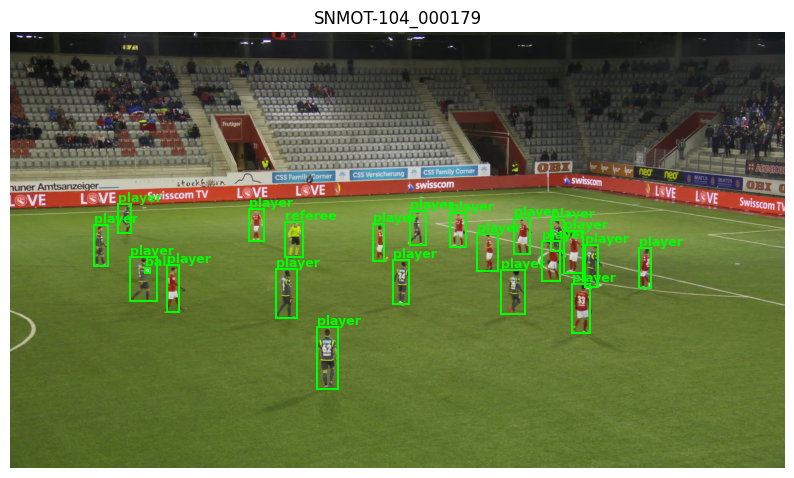

In [29]:

IMAGES_TRAIN = YOLO_ROOT / "images" / "train"
LABELS_TRAIN = YOLO_ROOT / "labels" / "train"

# Class mapping
ID2NAME = {
    0: "player",
    1: "referee",
    2: "ball"}

# Pick a random sample from train
label_path = random.choice(list(LABELS_TRAIN.glob("*.txt")))
image_path = IMAGES_TRAIN / f"{label_path.stem}.jpg"

print("Image:", image_path.name)
print("Label:", label_path.name)

# Read image
img = plt.imread(image_path)
h, w = img.shape[:2]

# Read YOLO labels: class x_center y_center w h (normalized)
boxes = []
with open(label_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        cls_id, x_c, y_c, bw, bh = map(float, line.split())
        cls_id = int(cls_id)

        x_c *= w
        y_c *= h
        bw *= w
        bh *= h

        x1 = x_c - bw / 2
        y1 = y_c - bh / 2

        boxes.append((cls_id, x1, y1, bw, bh))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img)

for cls_id, x1, y1, bw, bh in boxes:
    rect = Rectangle((x1, y1), bw, bh,
                     linewidth=1.5,
                     edgecolor="lime",
                     facecolor="none")
    ax.add_patch(rect)
    ax.text(x1, y1 - 5,
            ID2NAME.get(cls_id, str(cls_id)),
            color="lime",
            fontsize=9,
            weight="bold")

ax.set_title(label_path.stem)
ax.set_axis_off()
plt.show()
